We first install and import necessary packages.

In [1]:
!pip install torch
!pip install gymnasium
!pip install stable-baselines3

In [2]:
import gymnasium as gym

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as functional

import matplotlib.pyplot as plt

## Acrobot

Next, we instantiate the [Acrobot environment](https://www.gymlibrary.dev/environments/classic_control/acrobot/) from OpenAI Gym and gain a quick understanding of its key variables and methods.

The Acrobot environment includes a simple robot with two blue links that are connected by two green joints. The joint connecting the two links is actuated, i.e., it can be controlled by the robot by applying torque to the joint. The goal is to swing the free end of the outer link to reach the target height (shown as the black horizontal line) by using robot's actuation.

Follow the hyperlinks to learn more about the envionment [Acrobot environment](https://www.gymlibrary.dev/environments/classic_control/acrobot/)  and its [source code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py).

![](https://www.gymlibrary.dev/_images/acrobot.gif)

In [3]:
env = gym.make("Acrobot-v1")

#### States

OpenAI Gym environments do not explicitly provide state but instead provide observation. In the Acrobot environment, the state and observation are identical. The state of the Acrobot is a 6-dimensional vector, which provides information about the two rotational joint angles of the robot and their angular velocities. As joint angles and velocity are continuous variables, so is the Acrobot state.

In [4]:
print(f"Number of state features: {env.observation_space.shape[0]}")

Number of state features: 6


#### Actions

In contrast to the continuous state, the action space for this robot is discrete. The robot has only three choices:
- apply torque of unit 1 in clockwise direction,
- apply torque of until 1 in counter-clockwise direction, or
- apply no torque.

In [5]:
print(f"Number of actions: {env.action_space.n}")

Number of actions: 3


#### Transition and Reward Function

The transition and rewards functions for the environment are not explicitly represented as matrices or tensors. Instead the gym API provides access to the `step` method, which takes in as input an `action` and provides (among other things) an `observation` and `reward`. Also notice the `reset` method, which resets the MDP environment.

The following snippet describes the use of `step` and `reset` methods.

In [6]:
# Reset the environment
state = env.reset()
print(f"State: {state}")

# Select a random action to play
action = env.action_space.sample()
print(f"Action: {action}")

# Send this action to the environment to receive the next state and reward
next_state, reward, done, _, _ = env.step(action)
print(f"Next state: {next_state}")
print(f"Reward: {reward}")

State: (array([ 0.9975852 ,  0.06945387,  0.99767405,  0.06816484, -0.01699502,
       -0.03870964], dtype=float32), {})
Action: 0
Next state: [ 0.9973892   0.07221358  0.9996684   0.02574988  0.04271201 -0.37802354]
Reward: -1.0


## Problem 1.1

Next, we will implement the general recipe of Q Learning algorithm to compute the optimal policy in the Acrobot environment.

#### Q Network

Since, the robot's state space is continuous, we cannot represent the Q value function exactly. Instead, we will approximate the Q value as a neural network. Let us first define this neural network.

Many choices exist for the neural network architecture. We will utilize a multi-layer perceptron, with
- input as the state of the Acrobot, and
- output as a vector of size 3 denoting Q values of each action for the input state.

In [7]:
class QNetwork(nn.Module):
    """Approximates the Q Function as a Multi-Layer Perceptron."""

    def __init__(self, env, nodes_per_mlp_layer=[128, 64]):
        """Initialize the Q Function apprixmated as a Multi-Layer Perceptron.

        Args:
            env: An OpenAI Gym environment.
            nodes_per_mlp_layer: An array of integers. The length of array equals the number
                of hidden layers of the Multi-Layer Perceptron. Each element in the array
                equals the number of nodes in the corresponding layer.
        """
        super().__init__()

        # input layer
        n_observations = env.observation_space.shape[0]
        self.input_layer = nn.Linear(n_observations, nodes_per_mlp_layer[0])

        # hidden layers
        self.hidden_layers = nn.ModuleList()
        for k in range(len(nodes_per_mlp_layer) - 1):
            self.hidden_layers.append(nn.Linear(nodes_per_mlp_layer[k], nodes_per_mlp_layer[k + 1]))

        # output layer
        n_actions = env.action_space.n
        self.output_layer = nn.Linear(nodes_per_mlp_layer[-1], n_actions)

    def forward(self, x):
        """Implements the forward pass of the Q Network.

        Args:
            x: Input to the Q Network.

        Returns:
            Output of the Q Network.
        """
        x = functional.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = functional.relu(hidden_layer(x))
        x = self.output_layer(x)
        return x

#### Replay Buffer

In addition to the Q Network, our algorithm requires a data structure to store the agent's experiences: Replay Buffer. Let us now define this data structure.

Similar to Q Network, many data structure choices exist for the Replay Buffer. We will use a simple buffer to store agent's experiences.

In [8]:
class ReplayBuffer:
    """A buffer to store agent's experiences."""

    def __init__(self, env, buffer_size):
        """Initialize a ring buffer to store agent's experiences.

        Args:
            env: An OpenAI Gym environment.
            buffer_size: An integer. The total size of the buffer.
        """
        observation_n = env.observation_space.shape[0]
        self.buffer_size = buffer_size

        self.observations = np.zeros((self.buffer_size, observation_n), dtype=np.float32)
        self.next_observations = np.zeros((self.buffer_size, observation_n), dtype=np.float32)
        self.actions = np.zeros((self.buffer_size,), dtype=np.int64)
        self.rewards = np.zeros((self.buffer_size,), dtype=np.float32)
        self.dones = np.zeros((self.buffer_size,), dtype=np.float32)

        self.size = 0
        self.current = 0

    def add(self, state, action, next_state, reward, done):
        """Add an experience to the buffer.

        Args:
            state: the current environment state
            action: the action executed in the state
            next_state: the state after executing the action
            reward: the reward received after executing the action
            done: Boolean denoting whether the task is completed.
        """
        index = self.current

        self.observations[index] = state
        self.next_observations[index] = next_state
        self.actions[index] = action
        self.rewards[index] = reward
        self.dones[index] = done

        if self.size < self.buffer_size:
            self.size = self.size + 1

        self.current = self.current + 1
        if self.current == self.buffer_size:
            self.current = 0

    def sample(self, batch_size):
        """Sample a mini-batch of experiences from the replay buffer.

        Args:
            batch_size: An integer. The size of the mini-batch.

        Returns:
            Randomly sampled experiences from the replay buffer.
        """
        indices = np.random.randint(self.size, size=batch_size)
        observations = torch.from_numpy(self.observations[indices])
        next_observations = torch.from_numpy(self.next_observations[indices])
        actions = torch.from_numpy(self.actions[indices])
        rewards = torch.from_numpy(self.rewards[indices])
        dones = torch.from_numpy(self.dones[indices])

        return observations, actions, next_observations, rewards, dones

#### Exploration schedule

Q Learning typically utilizes epsilon-greedy strategy for exploration.

In general, it is useful to explore more initially (when the agent is far from the optimal policy) and less later on in the learning process. To implement this, we can implement a schedule for epsilon.

Similar to the Q network and replay buffer architectures, several choices exist for determining the epsilon schedule. We will use a simple linear scheduler to decay epsilon as agent gains more experience.

In [9]:
def linear_schedule_for_epsilon(initial_value, final_value, duration, timestep):
    """Implements a linear scheduler for epsilon.

    Args:
        initial_value: (float) Initial value of epsilon.
        final_value: (float) Final value of epsilon.
        duration: (int) Duration over which to decay epsilon from its initial to final value.
        timestep: (int) The current time step.

    Returns:
        Value of epsilon at the given timestep.
    """
    slope = (final_value - initial_value) / duration
    return max(slope * timestep + initial_value, final_value)

#### General recipe for Q Learning with Function Approximation

Now that we have all the building blocks, we will implement the general recipe for Q learning with function approximation.

We will use the AgentBase class from Assignment 2 to help us with the implementation.

In [10]:
class AgentBase:
    def __init__(self, env: gym.Env):
        self.env = env
        self.num_actions = self.env.action_space.n
        self.policy = self.make_policy()
        self.behavior_policy = self.make_behavior_policy()

    def make_policy(self):
        """
        Return a policy function that will be used for evaluation. The policy
        takes observation as input and return action
        """
        raise NotImplementedError

    def make_behavior_policy(self):
        """
        Similar to make_policy, it returns a policy function. But this one used
        for interaction with the environment.
        """
        raise NotImplementedError

    def run_episode(self, episode_policy):
        """
        Generate one episode with the given policy
        """
        episode = []
        done = False
        obs = self.env.reset()[0]
        episode_return = 0
        while not done:
            action = episode_policy(obs)
            next_obs, reward, done, truncated, _ = self.env.step(action)
            done = done or truncated
            episode.append([obs, action, reward, next_obs, done])
            obs = next_obs
            episode_return += reward

        return (episode, episode_return)

    def evaluate(self, num_eval_episodes=1000, plot_title="Evaluation"):
        """Evaluates the agent."""
        list_returns = []
        list_average_returns = []
        average_return = 0
        for episode_idx in range(num_eval_episodes):
            _, episode_return = self.run_episode(self.policy)
            average_return += (1. / (episode_idx+1)) * (episode_return - average_return)
            list_returns.append(episode_return)
            list_average_returns.append(average_return)

        print(f"Average reward {round(average_return, 3)}")
        plt.plot(list_returns,'^',label="Return")
        plt.plot(list_average_returns,'r',label="Average Return")
        plt.ylabel('Return')
        plt.xlabel('Episode#')
        plt.title(plot_title)
        plt.legend()
        plt.ylim(-501, 0.0)
        plt.show()

In [11]:
class DeepQLearning(AgentBase):
    """Implements a Q Learner with function approximation."""

    def __init__(self,
        env: gym.Env,
        buffer_size = 200000,
        batch_size = 64,
        initial_epsilon = 1.0,
        final_epsilon = 0.01,
        epsilon_decay_duration = 100000,
        learning_rate = 0.001,
        num_gradient_updates = 1,
        q_network_update_frequency = 1,
        target_network_update_frequency = 200,
        learning_starts_at_step = 10000):
        """Initializes the Agent.

        Args:
            env: An OpenAI Gym environment.
            buffer_size: (integer) Size of the replay buffer.
            batch_size: (integer) Size of the mini batch.
            initial_epsilon: (float) Initial value of epsilon.
            final_epsilon: (float) Final value of epsilon.
            epsilon_decay_duration: (integer) Duration over which to decay epsilon.
            learning_rate: (float) Learning rate for Q network update.
            num_gradient_updates: (integer) Number of stochastic gradient updates with each minibatch.
            q_network_update_frequency: (integer) Steps after which to update Q network.
            target_network_update_frequency: (integer) Steps after which to update target network.
            learning_starts_at_step: (integer) Step at which to begin learning. Before this, the
                agent explores and collects experiences in its replay buffer.
        """
        super().__init__(env=env)

        self.gamma = 0.99 # Assume a discount factor of 0.99
        self.current_step = 0
        self.learning_starts_at_step = learning_starts_at_step
        self.batch_size = batch_size
        self.num_gradient_updates = num_gradient_updates
        self.q_network_update_frequency = q_network_update_frequency
        self.target_network_update_frequency = target_network_update_frequency

        # Create exploration scheduler
        self.epsilon_scheduler = lambda current_step: linear_schedule_for_epsilon(
            initial_epsilon, final_epsilon, epsilon_decay_duration, current_step)
        
        self.q_network = QNetwork(env)
        self.target_network = QNetwork(env)
        self.replay_buffer = ReplayBuffer(env, buffer_size)
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)

        self.state = env.reset()[0]
        self.list_returns = []
        self.list_average_returns = []
        self.average_return = 0.
        self.list_moving_average_returns = []
        self.moving_average_returns_by_step = np.empty([200000])

    @property
    def epsilon(self):
        return self.epsilon_scheduler(self.current_step)

    def make_policy(self):
        def policy_func(observation):
            n = np.random.uniform()
            if n < self.epsilon:
                action = self.env.action_space.sample()
            else:
                state = torch.from_numpy(observation)
                action_probs: torch.Tensor = self.q_network(state)
                action_probs: np.ndarray = action_probs.detach().numpy()
                action = np.argmax(action_probs)
            return action
        return policy_func

    def make_behavior_policy(self):
        def policy_func(observation):
            n = np.random.uniform()
            if n < self.epsilon:
                action = self.env.action_space.sample()
            else:
                state = torch.from_numpy(observation)
                action_probs: torch.Tensor = self.q_network(state)
                action_probs: np.ndarray = action_probs.detach().numpy()
                action = np.argmax(action_probs)
            return action

        return policy_func

    def update(self):
        """Update the agent."""
        if self.current_step >= self.learning_starts_at_step:

            if self.current_step % self.q_network_update_frequency == 0:
                observations, actions, next_observations, rewards, dones = self.replay_buffer.sample(self.batch_size)

                actions_probs: torch.Tensor = self.q_network(observations)
                values: torch.Tensor = actions_probs.gather(dim=1, index=actions.view(-1, 1))

                actions_probs: torch.Tensor = self.target_network(next_observations)
                max_next_targets: torch.Tensor = actions_probs.max(dim=1)[0].view(-1, 1)
                targets: torch.Tensor = rewards.view(-1, 1) + self.gamma * max_next_targets * (1 - dones.view(-1, 1))
                
                self.optimizer.zero_grad()
                loss = torch.mean(functional.mse_loss(values, targets))
                loss.backward()
                self.optimizer.step()

                self.num_gradient_updates = self.num_gradient_updates + 1
                if self.num_gradient_updates % self.target_network_update_frequency == 0:
                    self.target_network.load_state_dict(self.q_network.state_dict())


    def train(self, num_train_episodes, make_plot=False):

        for episode_idx in range(num_train_episodes):
            # Reset environment before beginning the episode
            done = False
            self.state = self.env.reset()[0]
            episode_return = 0

            # Run the episode and update the policy
            while not done:
                # First, generate a step with behavior policy
                action = self.behavior_policy(self.state)
                next_state, reward, done, truncated, _ = self.env.step(action)
                done = done or truncated

                # Update the replay buffer
                self.replay_buffer.add(self.state, action, next_state, reward, done)

                # Second, update the agent
                self.update()

                # Prepare for next step
                self.state = next_state
                self.current_step += 1
                episode_return += reward
                if self.current_step < 200000:
                    if len(self.list_moving_average_returns) > 0:
                      self.moving_average_returns_by_step[self.current_step] = self.list_moving_average_returns[-1]
                    else:
                      self.moving_average_returns_by_step[self.current_step] = -500.

                if self.current_step % 10000 == 0:
                    print(f"Timestep: {self.current_step}, episode reward (moving average, 20 episodes): {round(self.list_moving_average_returns[-1],2)}")

            # Store the return for evaluation
            self.list_returns.append(episode_return)
            self.average_return = np.mean(np.asarray(self.list_returns))
            self.list_average_returns.append(self.average_return)

            if len(self.list_returns) > 20:
                self.list_moving_average_returns.append(
                  np.mean(np.asarray(self.list_returns[-20:])))
            else:
                self.list_moving_average_returns.append(self.average_return)

        if make_plot:
            plt.plot(self.list_returns,'^',label="Return")
            plt.plot(self.list_average_returns,'r',label="Average Return (all episodes)")
            plt.plot(self.list_moving_average_returns,'b',label="Average Return (last 20 episodes)")
            plt.ylabel('Return')
            plt.xlabel('Episode#')
            plt.title('Performance during training')
            plt.ylim(-501, 0.0)
            plt.legend()
            plt.show()

#### Training the Agent

Having implemented the agent, now we will train it using the default hyperparameters provided in the class definition and observe its performance.

In [12]:
env = gym.make("Acrobot-v1")
agent_001 = DeepQLearning(env)

Average reward -500.0


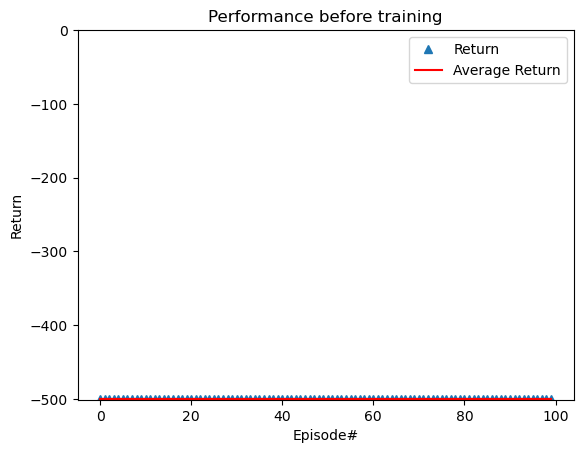

In [13]:
agent_001.evaluate(plot_title="Performance before training", num_eval_episodes=100)

Timestep: 10000, episode reward (moving average, 20 episodes): -494.05
Timestep: 20000, episode reward (moving average, 20 episodes): -473.2
Timestep: 30000, episode reward (moving average, 20 episodes): -298.15
Timestep: 40000, episode reward (moving average, 20 episodes): -183.2
Timestep: 50000, episode reward (moving average, 20 episodes): -162.85
Timestep: 60000, episode reward (moving average, 20 episodes): -157.95
Timestep: 70000, episode reward (moving average, 20 episodes): -105.25
Timestep: 80000, episode reward (moving average, 20 episodes): -102.4
Timestep: 90000, episode reward (moving average, 20 episodes): -95.5
Timestep: 100000, episode reward (moving average, 20 episodes): -84.9
Timestep: 110000, episode reward (moving average, 20 episodes): -91.6
Timestep: 120000, episode reward (moving average, 20 episodes): -81.8
Timestep: 130000, episode reward (moving average, 20 episodes): -80.05


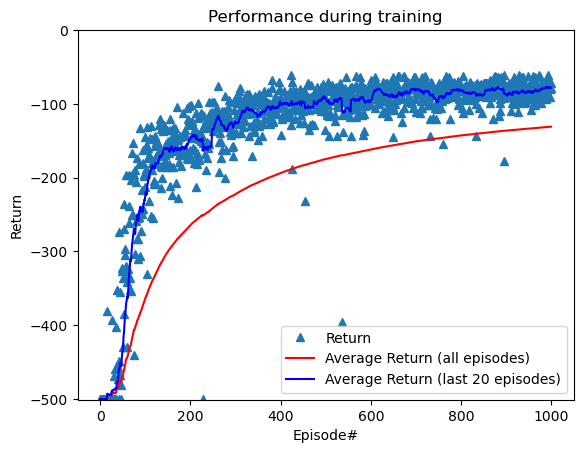

In [14]:
agent_001.train(1000, make_plot=True)

Average reward -81.57


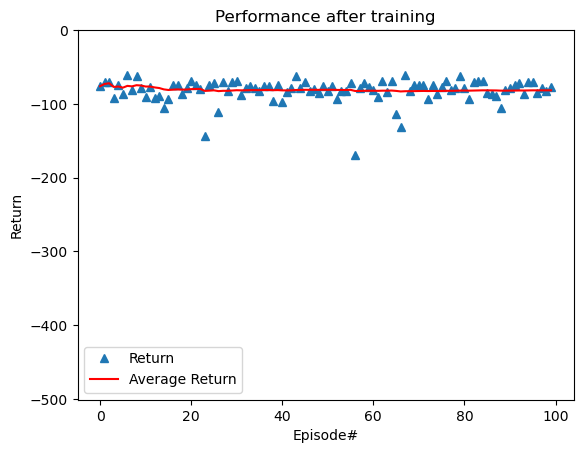

In [15]:
agent_001.evaluate(plot_title="Performance after training", num_eval_episodes=100)

## Problem 1.2

Now that we have implemented the general recipe, let us run ablation studies to assess importance of different components of the Deep Q Learning algorithm.

First, we will implement and assess the performance of the original Q Learning with naive function approximation, i.e., without the use of replay buffer and target networks. Note that this is a special case of our general recipe and, in general, we do not expect to work in practice. Let us see if it works for the Acrobot environment.

In [16]:
class OnlineDeepQLearning(DeepQLearning):
    """Implements Online Q Learner with function approximation."""

    def __init__(self, env):
        super().__init__(
            env = env,
            # without replay buffer
            buffer_size = 1,
            batch_size = 1,
            # without target network
            target_network_update_frequency = 1,
        )


In [17]:
env = gym.make("Acrobot-v1")
agent_002 = OnlineDeepQLearning(env)

Timestep: 10000, episode reward (moving average, 20 episodes): -499.85
Timestep: 20000, episode reward (moving average, 20 episodes): -488.95
Timestep: 30000, episode reward (moving average, 20 episodes): -491.2
Timestep: 40000, episode reward (moving average, 20 episodes): -500.0
Timestep: 50000, episode reward (moving average, 20 episodes): -500.0
Timestep: 60000, episode reward (moving average, 20 episodes): -496.95
Timestep: 70000, episode reward (moving average, 20 episodes): -495.75
Timestep: 80000, episode reward (moving average, 20 episodes): -500.0
Timestep: 90000, episode reward (moving average, 20 episodes): -445.35
Timestep: 100000, episode reward (moving average, 20 episodes): -436.6
Timestep: 110000, episode reward (moving average, 20 episodes): -500.0
Timestep: 120000, episode reward (moving average, 20 episodes): -500.0
Timestep: 130000, episode reward (moving average, 20 episodes): -500.0
Timestep: 140000, episode reward (moving average, 20 episodes): -500.0
Timestep: 

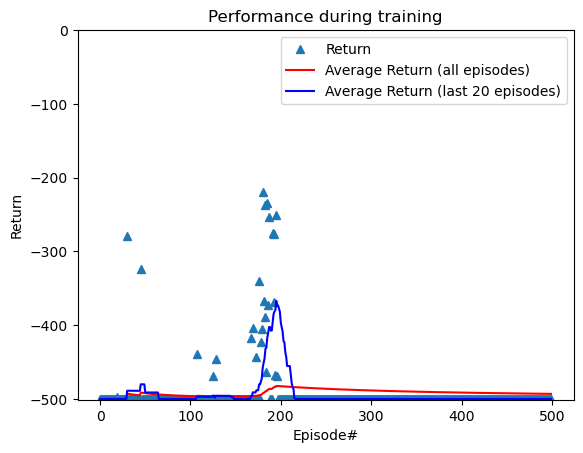

In [18]:
agent_002.train(500, make_plot=True)

Now let us bring back one of the components at a time that made the algorithm successful in Problem 1. First, we will bring back only the replay buffer (and not the target network) and observe its effect on the agent's performance.

In [19]:
class DeepQLearningWithoutTargetNetwork(DeepQLearning):
    """Implements a Deep Q Learner without target network."""

    def __init__(self, env):
        super().__init__(
            env = env,
            # without target network
            target_network_update_frequency = 1,
        )

In [20]:
env = gym.make("Acrobot-v1")
agent_003 = DeepQLearningWithoutTargetNetwork(env)

Timestep: 10000, episode reward (moving average, 20 episodes): -500.0
Timestep: 20000, episode reward (moving average, 20 episodes): -496.9
Timestep: 30000, episode reward (moving average, 20 episodes): -449.55
Timestep: 40000, episode reward (moving average, 20 episodes): -246.2
Timestep: 50000, episode reward (moving average, 20 episodes): -195.9
Timestep: 60000, episode reward (moving average, 20 episodes): -187.95
Timestep: 70000, episode reward (moving average, 20 episodes): -151.35
Timestep: 80000, episode reward (moving average, 20 episodes): -116.9
Timestep: 90000, episode reward (moving average, 20 episodes): -105.4
Timestep: 100000, episode reward (moving average, 20 episodes): -119.4
Timestep: 110000, episode reward (moving average, 20 episodes): -86.4
Timestep: 120000, episode reward (moving average, 20 episodes): -92.3
Timestep: 130000, episode reward (moving average, 20 episodes): -90.6
Timestep: 140000, episode reward (moving average, 20 episodes): -97.2


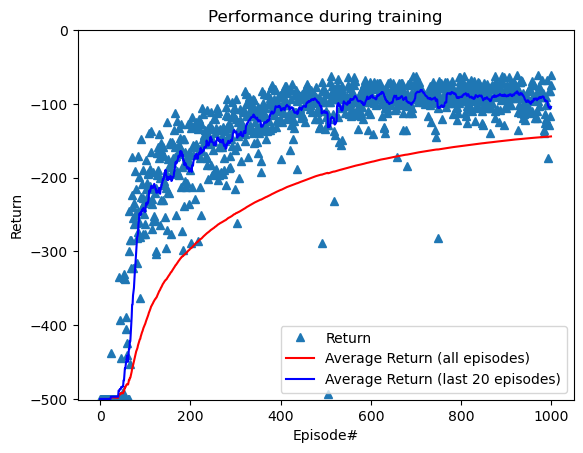

In [21]:
agent_003.train(1000, make_plot=True)

Next, we will bring back only the target network (and not the replay buffer) and observe its effect on the agent's performance.

In [22]:
class DeepQLearningWithoutReplayBuffer(DeepQLearning):
    """Implements a Deep Q Learner without replay buffer."""
    def __init__(self, env):
        super().__init__(
            env = env,
            # without replay buffer
            buffer_size = 1,
            batch_size = 1,
        )


In [23]:
env = gym.make("Acrobot-v1")
agent_004 = DeepQLearningWithoutReplayBuffer(env)

Timestep: 10000, episode reward (moving average, 20 episodes): -498.35
Timestep: 20000, episode reward (moving average, 20 episodes): -494.3
Timestep: 30000, episode reward (moving average, 20 episodes): -457.25
Timestep: 40000, episode reward (moving average, 20 episodes): -298.9
Timestep: 50000, episode reward (moving average, 20 episodes): -217.85
Timestep: 60000, episode reward (moving average, 20 episodes): -192.05
Timestep: 70000, episode reward (moving average, 20 episodes): -157.5
Timestep: 80000, episode reward (moving average, 20 episodes): -139.6
Timestep: 90000, episode reward (moving average, 20 episodes): -158.35
Timestep: 100000, episode reward (moving average, 20 episodes): -276.95
Timestep: 110000, episode reward (moving average, 20 episodes): -327.05
Timestep: 120000, episode reward (moving average, 20 episodes): -279.8
Timestep: 130000, episode reward (moving average, 20 episodes): -451.0
Timestep: 140000, episode reward (moving average, 20 episodes): -418.1
Timestep

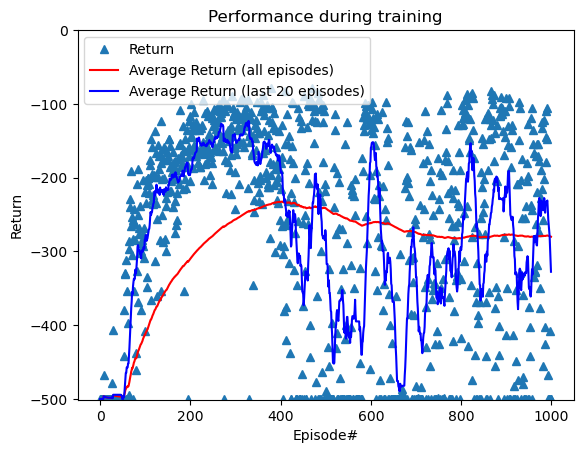

In [24]:
agent_004.train(1000, make_plot=True)

In a single plot, show the performance of the four variants that you have implemented above. Specifications of the plot
- X axis: Number of Timesteps (0 to 100000)
- Y axis: 20-episode simple moving average of episodic rewards.

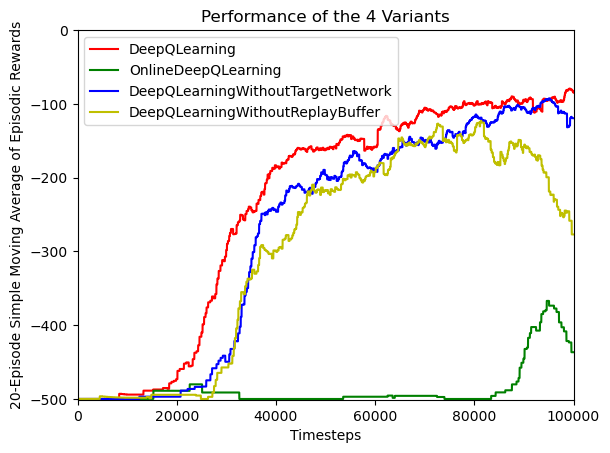

In [25]:
plt.plot(agent_001.moving_average_returns_by_step,'r',label="DeepQLearning")
plt.plot(agent_002.moving_average_returns_by_step,'g',label="OnlineDeepQLearning")
plt.plot(agent_003.moving_average_returns_by_step,'b',label="DeepQLearningWithoutTargetNetwork")
plt.plot(agent_004.moving_average_returns_by_step,'y',label="DeepQLearningWithoutReplayBuffer")
plt.ylabel('20-Episode Simple Moving Average of Episodic Rewards')
plt.xlabel('Timesteps')
plt.title('Performance of the 4 Variants')
plt.ylim(-501, 0.0)
plt.xlim(0, 100000)
plt.legend()
plt.show()

## Problem 1.3

Select any one hyperparameter of the DeepQLearning agent and study its effect on the agent's performance. You should try at least five different values of this hyperparameter. In a single plot, show the performance of the agent for different values of hyperparameter.  Specifications of the plot
- X axis: Number of Timesteps (0 to 100000)
- Y axis: 20-episode simple moving average of episodic rewards.


In [26]:
learning_rates = [
    0.0001,
    0.0003,
    0.001,
    0.003,
    0.01,
]
agents = []
for learning_rate in learning_rates:
    agent = DeepQLearning(env, learning_rate=learning_rate)
    agent.train(1000, make_plot=False)
    agents.append(agent)

Timestep: 10000, episode reward (moving average, 20 episodes): -500.0
Timestep: 20000, episode reward (moving average, 20 episodes): -441.65
Timestep: 30000, episode reward (moving average, 20 episodes): -258.4
Timestep: 40000, episode reward (moving average, 20 episodes): -204.45
Timestep: 50000, episode reward (moving average, 20 episodes): -157.8
Timestep: 60000, episode reward (moving average, 20 episodes): -144.9
Timestep: 70000, episode reward (moving average, 20 episodes): -113.35
Timestep: 80000, episode reward (moving average, 20 episodes): -108.0
Timestep: 90000, episode reward (moving average, 20 episodes): -98.4
Timestep: 100000, episode reward (moving average, 20 episodes): -84.25
Timestep: 110000, episode reward (moving average, 20 episodes): -77.65
Timestep: 120000, episode reward (moving average, 20 episodes): -87.55
Timestep: 130000, episode reward (moving average, 20 episodes): -83.75
Timestep: 10000, episode reward (moving average, 20 episodes): -499.7
Timestep: 2000

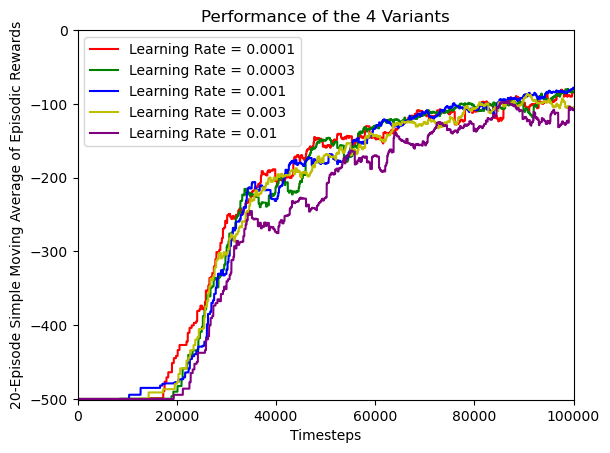

In [27]:
colors = ['r', 'g', 'b', 'y', 'purple']
for agent, color, learning_rate in zip(agents, colors, learning_rates):
    plt.plot(agent.moving_average_returns_by_step, color, label=f"Learning Rate = {learning_rate}")
plt.ylabel('20-Episode Simple Moving Average of Episodic Rewards')
plt.xlabel('Timesteps')
plt.title('Five different values of this hyperparameter')
plt.ylim(-5001, 0.0)
plt.xlim(0, 100000)
plt.legend()
plt.show()

## Problem 1.4

While applying RL in real world, you may consider the use of off-the-shelf implementation of RL algorithms. The package [Stable Baselines 3](stable-baselines3.readthedocs.io/) aims to provide a set of reliable implementations of RL algorithms in PyTorch.

Familiarize yourself with this package and use its implementation of Deep Q Network to learn the optimal policy for the Acrobot environment.

In [28]:
from typing import Any, Callable, Dict, List, Optional, Union

import gymnasium as gym
import numpy as np

from stable_baselines3.common.callbacks import EventCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecEnv, sync_envs_normalization


class MyEvalCallback(EventCallback):
    """
    Callback for evaluating an agent.

    .. warning::

      When using multiple environments, each call to  ``env.step()``
      will effectively correspond to ``n_envs`` steps.
      To account for that, you can use ``eval_freq = max(eval_freq // n_envs, 1)``

    :param eval_env: The environment used for initialization
    :param callback_on_new_best: Callback to trigger
        when there is a new best model according to the ``mean_reward``
    :param callback_after_eval: Callback to trigger after every evaluation
    :param n_eval_episodes: The number of episodes to test the agent
    :param eval_freq: Evaluate the agent every ``eval_freq`` call of the callback.
    :param deterministic: Whether the evaluation should
        use a stochastic or deterministic actions.
    :param render: Whether to render or not the environment during evaluation
    :param verbose: Verbosity level: 0 for no output, 1 for indicating information about evaluation results
    :param warn: Passed to ``evaluate_policy`` (warns if ``eval_env`` has not been
        wrapped with a Monitor wrapper)
    """

    def __init__(
        self,
        eval_env: Union[gym.Env, VecEnv],
        n_eval_episodes: int = 5,
        eval_freq: int = 10000,
        deterministic: bool = True,
        render: bool = False,
        verbose: int = 1,
        warn: bool = True,
    ):
        super().__init__(None, verbose=verbose)

        self.n_eval_episodes = n_eval_episodes
        self.eval_freq = eval_freq
        self.deterministic = deterministic
        self.render = render
        self.warn = warn

        self.eval_env = eval_env
        self.evaluations_results = []
        self.evaluations_timesteps = []
        self.evaluations_length = []

    def _on_step(self) -> bool:
        continue_training = True

        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            # Sync training and eval env if there is VecNormalize
            if self.model.get_vec_normalize_env() is not None:
                try:
                    sync_envs_normalization(self.training_env, self.eval_env)
                except AttributeError as e:
                    raise AssertionError(
                        "Training and eval env are not wrapped the same way, "
                        "see https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html#evalcallback "
                        "and warning above."
                    ) from e

            episode_rewards, episode_lengths = evaluate_policy(
                self.model,
                self.eval_env,
                n_eval_episodes=self.n_eval_episodes,
                render=self.render,
                deterministic=self.deterministic,
                return_episode_rewards=True,
                warn=self.warn,
            )

            mean_reward, std_reward = np.mean(episode_rewards), np.std(episode_rewards)

            self.evaluations_timesteps.append(self.num_timesteps)
            self.evaluations_results.append(mean_reward)
            self.evaluations_length.append(episode_lengths)

        return continue_training


In [29]:
# refs: https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/dqn.yml
# # Tuned
# Acrobot-v1:
#   n_timesteps: !!float 1e5
#   policy: 'MlpPolicy'
#   learning_rate: !!float 6.3e-4
#   batch_size: 128
#   buffer_size: 50000
#   learning_starts: 0
#   gamma: 0.99
#   target_update_interval: 250
#   train_freq: 4
#   gradient_steps: -1
#   exploration_fraction: 0.12
#   exploration_final_eps: 0.1
#   policy_kwargs: "dict(net_arch=[256, 256])"

import os
from stable_baselines3 import DQN

model = DQN(
    policy="MlpPolicy",
    env=env,
    learning_rate=6.3e-4,
    batch_size=128,
    buffer_size=50000,
    learning_starts=0,
    gamma=0.99,
    target_update_interval=250,
    train_freq=4,
    gradient_steps=-1,
    exploration_fraction=0.12,
    exploration_final_eps=0.1,
    policy_kwargs=dict(net_arch=[256, 256]),
    # stats_window_size=20,
)

eval_callback = MyEvalCallback(
    env,
    eval_freq=int(1e3),
    n_eval_episodes=20,
    deterministic=True,
    render=False,
    verbose=0,
)
model.learn(total_timesteps=int(1e5), log_interval=4, callback=eval_callback)


/Users/rjy/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In a single plot, compare the performance of your implementation of the algorithm in 1.1. with the on in 1.4
- X axis: Number of Timesteps (0 to 100000)
- Y axis: 20-episode simple moving average of episodic rewards.

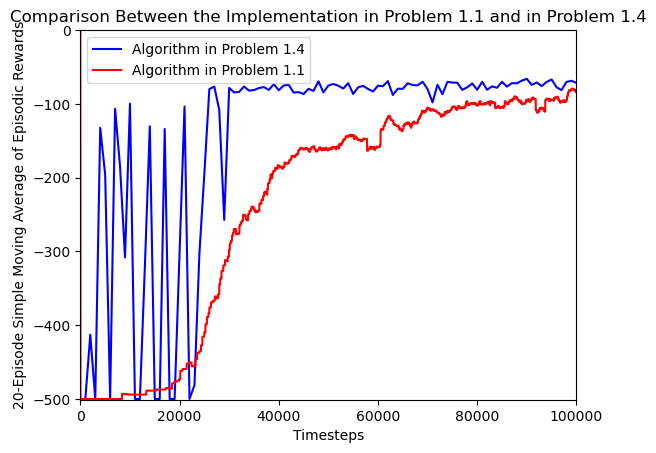

In [30]:
plt.plot(eval_callback.evaluations_timesteps, eval_callback.evaluations_results, "b", label="Algorithm in Problem 1.4")
plt.plot(agent_001.moving_average_returns_by_step, "r", label="Algorithm in Problem 1.1")
plt.ylabel("20-Episode Simple Moving Average of Episodic Rewards")
plt.xlabel("Timesteps")
plt.title("Comparison Between the Implementation in Problem 1.1 and in Problem 1.4")
plt.ylim(-501, 0.0)
plt.xlim(0, 100000)
plt.legend()
plt.show()